In [1]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
from collections import defaultdict

In [2]:
# -------------------------
# 1. CUSTOM BLACKJACK ENVIRONMENT
# -------------------------
class BlackjackEnv(gym.Env):
    """
    A simplified blackjack environment supporting:
      - HIT (0): take a new card,
      - STK (1): stick (stand),
      - DBL (2): double down (double the bet, draw one card, then stand),
      - SUR (3): surrender (forfeit half the bet).
    
    It implements a natural blackjack rule:
      - if the player's initial hand is an Ace and a 10‐value card, and the dealer does not also have blackjack,
        then the reward is +1.5 (i.e. 3:2 payout).
        
    For simplicity:
      - An infinite deck is assumed.
      - Dealer stands on 17.
      - The “insurance” option is not explicitly modeled.
      - Only on the very first decision are DBL and SUR allowed; afterwards only HIT and STK.
    """
    
    def __init__(self, natural=True):
        super(BlackjackEnv, self).__init__()
        self.action_space = spaces.Discrete(4)  # actions 0=HIT, 1=STK, 2=DBL, 3=SUR
        # The observation is a tuple: (player_sum, dealer_first_card, usable_ace, first_move_flag)
        self.observation_space = spaces.Tuple((
            spaces.Discrete(32),   # player sum up to 31 (for safety)
            spaces.Discrete(11),   # dealer card: 1..10 (Ace is 1)
            spaces.Discrete(2),    # usable ace: 0 (False) or 1 (True)
            spaces.Discrete(2)     # first_move: 0 or 1 (True on first decision)
        ))
        self.natural = natural
        self.seed()
        self.reset()
        
    def seed(self, seed=None):
        random.seed(seed)
        np.random.seed(seed)
        
    def draw_card(self):
        # Cards: Ace=1, 2-9 as numbers, and 10 representing 10, J, Q, K.
        cards = [1,2,3,4,5,6,7,8,9,10,10,10,10]
        return random.choice(cards)
    
    def draw_hand(self):
        return [self.draw_card(), self.draw_card()]
    
    def usable_ace(self, hand):
        # Returns True if an Ace is counted as 11 (i.e. if adding 10 doesn’t bust)
        return 1 in hand and sum(hand) + 10 <= 21
    
    def sum_hand(self, hand):
        s = sum(hand)
        if self.usable_ace(hand):
            return s + 10
        return s
    
    def is_bust(self, hand):
        return self.sum_hand(hand) > 21
    
    def is_natural(self, hand):
        # Check for natural blackjack: an Ace and a 10-value card.
        return sorted(hand) == [1, 10]
    
    def _get_obs(self):
        # Observation: (player sum, dealer's visible card, usable ace flag, first_move flag)
        return (self.sum_hand(self.player), self.dealer[0], int(self.usable_ace(self.player)), int(self.first_move))
    
    def _dealer_play(self):
        # Dealer draws until reaching 17 or more.
        while self.sum_hand(self.dealer) < 17:
            self.dealer.append(self.draw_card())
        player_sum = self.sum_hand(self.player) if not self.is_bust(self.player) else 0
        dealer_sum = self.sum_hand(self.dealer) if not self.is_bust(self.dealer) else 0
        
        # Check for natural blackjack (only relevant if player has two cards)
        if self.natural and len(self.player) == 2 and self.is_natural(self.player):
            if len(self.dealer) == 2 and self.is_natural(self.dealer):
                return 0    # push
            else:
                return 1.5 * self.current_bet  # blackjack payout
        
        if dealer_sum > 21:  # dealer busts
            return self.current_bet
        if player_sum > dealer_sum:
            return self.current_bet
        elif player_sum == dealer_sum:
            return 0
        else:
            return -self.current_bet
        
    def step(self, action):
        """
        Take an action:
         0: HIT – add a card;
         1: STK – stick and let dealer play;
         2: DBL – double bet, get one card and then stand;
         3: SUR – surrender (lose half the bet).
        If not the first move, DBL and SUR are not allowed; here we force them to act as HIT.
        """
        if self.done:
            return self._get_obs(), 0, self.done, {}
        
        if action not in [0,1,2,3]:
            raise ValueError("Invalid action")
        
        # Only on first move can the player double or surrender.
        if not self.first_move and action in [2,3]:
            action = 0  # force HIT
        
        # After the first decision, mark that subsequent decisions are not first moves.
        self.first_move = False
        
        if action == 0:  # HIT
            card = self.draw_card()
            self.player.append(card)
            if self.is_bust(self.player):
                reward = -self.current_bet
                self.done = True
            else:
                reward = 0
        elif action == 1:  # STK (stick)
            reward = self._dealer_play()
            self.done = True
        elif action == 2:  # DBL (double)
            self.current_bet *= 2  # double the wager
            card = self.draw_card()
            self.player.append(card)
            if self.is_bust(self.player):
                reward = -self.current_bet
            else:
                reward = self._dealer_play()
            self.done = True
        elif action == 3:  # SUR (surrender)
            reward = -0.5 * self.current_bet
            self.done = True
            
        return self._get_obs(), reward, self.done, {}
    
    def reset(self, *, seed=None, options=None):
        # Start a new round.
        self.done = False
        self.current_bet = 1  # We use unit bet; later the loss percentages are computed relative to total wager.
        self.player = self.draw_hand()
        self.dealer = self.draw_hand()
        self.first_move = True
        
        # If natural blackjack occurs immediately, end the round.
        if self.natural and self.is_natural(self.player):
            if self.is_natural(self.dealer):
                self.done = True
                self.last_reward = 0
            else:
                self.done = True
                self.last_reward = 1.5 * self.current_bet
        return self._get_obs()


In [5]:

# -------------------------
# 2. MONTE CARLO RL TRAINING
# -------------------------
# We use first–visit Monte Carlo control with epsilon–greedy policy.
# (Note: The state here is a tuple: (player_sum, dealer_card, usable_ace, first_move))
#
# For the final “strategy chart” we will later extract the learned best actions for the initial decision states.
#
env = BlackjackEnv(natural=True)
num_episodes = 10_000_000  # Change this (e.g. to 100_000) for a quick test; 10M is intended for full training.

# We store Q-values and also cumulative returns for each (state, action)
Q = defaultdict(lambda: np.zeros(4))
returns_sum = defaultdict(lambda: np.zeros(4))
returns_count = defaultdict(lambda: np.zeros(4))

# Epsilon parameter for epsilon–greedy behavior
epsilon = 0.1

def get_allowed_actions(state):
    # Only on the first move are all four actions allowed; afterwards only HIT (0) and STK (1).
    if state[3] == 1:
        return [0, 1, 2, 3]
    else:
        return [0, 1]

def policy_fn(state):
    """Return an action following epsilon–greedy policy based on Q."""
    allowed = get_allowed_actions(state)
    action_values = Q[state]
    # Find the best (highest Q) among allowed actions
    best_action = None
    best_value = -float('inf')
    for a in allowed:
        if action_values[a] > best_value:
            best_value = action_values[a]
            best_action = a
    # Build probability distribution over the 4 actions: assign zero to disallowed ones.
    probs = np.zeros(4)
    for a in allowed:
        probs[a] = epsilon / len(allowed)
    probs[best_action] += 1 - epsilon
    return np.random.choice(np.arange(4), p=probs)

# To track the cumulative loss percentage over episodes:
total_wagered = 0.0
total_loss = 0.0
loss_percentages = []
episodes_axis = []
episode_interval = 100_000  # record statistics every 100k episodes

print("Starting training...")
for i_episode in range(1, num_episodes+1):
    episode = []  # list of (state, action, reward, wager) tuples
    state = env.reset()
    # If the round ended immediately (e.g. due to natural blackjack) then no decision is made.
    if env.done:
        reward = env.last_reward if hasattr(env, 'last_reward') else 0
        total_wagered += env.current_bet
        total_loss += -reward
        if i_episode % episode_interval == 0:
            loss_pct = (total_loss / total_wagered) * 100
            loss_percentages.append(loss_pct)
            episodes_axis.append(i_episode)
        continue
    
    # Generate an episode following the current policy.
    while True:
        action = policy_fn(state)
        next_state, reward, done, _ = env.step(action)
        episode.append((state, action, reward, env.current_bet))
        state = next_state
        if done:
            break

    # For statistics: the wager for the round is the final current_bet
    wager = episode[-1][3]
    total_wagered += wager
    final_reward = reward  # the reward from the terminal step
    total_loss += -final_reward
        
    # First-visit MC update: since only the terminal reward is nonzero,
    # every state–action pair in the episode gets the same return G.
    G = final_reward
    visited = set()
    for (s, a, r, bet) in episode:
        if (s, a) not in visited:
            returns_sum[s][a] += G
            returns_count[s][a] += 1
            Q[s][a] = returns_sum[s][a] / returns_count[s][a]
            visited.add((s, a))
            
    if i_episode % episode_interval == 0:
        loss_pct = (total_loss / total_wagered) * 100
        loss_percentages.append(loss_pct)
        episodes_axis.append(i_episode)
        print(f"Episode {i_episode:,}/{num_episodes:,}: Cumulative Loss% = {loss_pct:.2f}")

print("Training complete!")

Starting training...
Episode 200,000/10,000,000: Cumulative Loss% = 9.05
Episode 300,000/10,000,000: Cumulative Loss% = 8.14
Episode 400,000/10,000,000: Cumulative Loss% = 7.62
Episode 500,000/10,000,000: Cumulative Loss% = 7.18
Episode 600,000/10,000,000: Cumulative Loss% = 6.94
Episode 700,000/10,000,000: Cumulative Loss% = 6.67
Episode 800,000/10,000,000: Cumulative Loss% = 6.50
Episode 900,000/10,000,000: Cumulative Loss% = 6.28
Episode 1,000,000/10,000,000: Cumulative Loss% = 6.16
Episode 1,100,000/10,000,000: Cumulative Loss% = 6.01
Episode 1,200,000/10,000,000: Cumulative Loss% = 5.90
Episode 1,300,000/10,000,000: Cumulative Loss% = 5.85
Episode 1,400,000/10,000,000: Cumulative Loss% = 5.77
Episode 1,500,000/10,000,000: Cumulative Loss% = 5.74
Episode 1,600,000/10,000,000: Cumulative Loss% = 5.69
Episode 1,700,000/10,000,000: Cumulative Loss% = 5.63
Episode 1,800,000/10,000,000: Cumulative Loss% = 5.58
Episode 2,000,000/10,000,000: Cumulative Loss% = 5.52
Episode 2,100,000/10,00


Evaluation Results (over 100000 episodes):
Win%: 41.03%, Loss%: 51.04%, Draw%: 7.93%


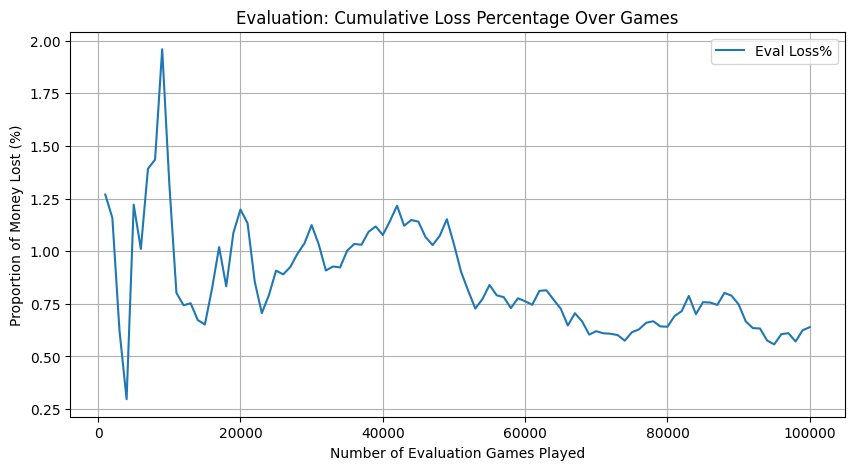

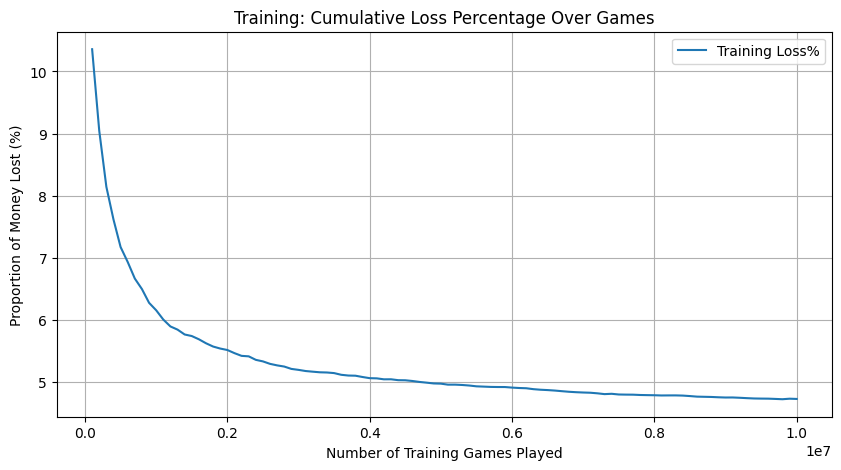

In [6]:
# -------------------------
# 3. EVALUATION OF THE TRAINED MODEL
# -------------------------
# We now run (say) 100,000 evaluation episodes using a greedy policy (epsilon=0)
# and also compute the percentages of wins, losses, and draws.
eval_episodes = 100_000
wins = 0
losses = 0
draws = 0
eval_total_wagered = 0.0
eval_total_loss = 0.0
eval_loss_percentages = []
eval_episodes_axis = []

for i in range(1, eval_episodes+1):
    state = env.reset()
    if env.done:
        final_reward = env.last_reward if hasattr(env, 'last_reward') else 0
    else:
        while True:
            # Greedy action: choose the best among allowed actions
            allowed = get_allowed_actions(state)
            action_values = Q[state]
            best_action = None
            best_value = -float('inf')
            for a in allowed:
                if action_values[a] > best_value:
                    best_value = action_values[a]
                    best_action = a
            action = best_action
            next_state, reward, done, _ = env.step(action)
            state = next_state
            if done:
                final_reward = reward
                break
    wager = env.current_bet
    eval_total_wagered += wager
    eval_total_loss += -final_reward
    if final_reward < 0:
        losses += 1
    elif final_reward > 0:
        wins += 1
    else:
        draws += 1
    
    if i % 1000 == 0:
        loss_pct = (eval_total_loss / eval_total_wagered) * 100
        eval_loss_percentages.append(loss_pct)
        eval_episodes_axis.append(i)

win_pct = wins / eval_episodes * 100
loss_pct_final = losses / eval_episodes * 100
draw_pct = draws / eval_episodes * 100
print("\nEvaluation Results (over {} episodes):".format(eval_episodes))
print(f"Win%: {win_pct:.2f}%, Loss%: {loss_pct_final:.2f}%, Draw%: {draw_pct:.2f}%")

# Plot the evaluation graph (loss percentage vs. games played)
plt.figure(figsize=(10,5))
plt.plot(eval_episodes_axis, eval_loss_percentages, label="Eval Loss%")
plt.xlabel("Number of Evaluation Games Played")
plt.ylabel("Proportion of Money Lost (%)")
plt.title("Evaluation: Cumulative Loss Percentage Over Games")
plt.legend()
plt.grid(True)
plt.show()

# Also plot the training graph (if desired)
plt.figure(figsize=(10,5))
plt.plot(episodes_axis, loss_percentages, label="Training Loss%")
plt.xlabel("Number of Training Games Played")
plt.ylabel("Proportion of Money Lost (%)")
plt.title("Training: Cumulative Loss Percentage Over Games")
plt.legend()
plt.grid(True)
plt.show()

In [7]:
# -------------------------
# 4. FINAL STRATEGY CHART EXTRACTION
# -------------------------
# We now extract the “optimal” (greedy) action for each state in which a decision is made.
# For the final strategy chart we restrict ourselves to the first–move states.
# We build two tables:
#   - One for “hard” totals: player total from 5 to 20 (usable_ace==0)
#   - One for “soft” totals: player total from 13 to 20 (usable_ace==1)
#
# The dealer’s upcard is taken as 2–10 and Ace (represented by 1 in our environment).

actions_map = {0: "HIT", 1: "STK", 2: "DBL", 3: "SUR"}

# Build chart for hard totals
hard_data = {}
for player_total in range(5, 21):
    row = {}
    for dealer_card in [2,3,4,5,6,7,8,9,10,1]:  # note: dealer Ace is represented as 1; we will display it as "A"
        state = (player_total, dealer_card, 0, 1)  # first_move==True, usable_ace==False
        if state in Q:
            allowed = get_allowed_actions(state)
            action_values = Q[state]
            best_action = None
            best_value = -float('inf')
            for a in allowed:
                if action_values[a] > best_value:
                    best_value = action_values[a]
                    best_action = a
            col = "A" if dealer_card == 1 else str(dealer_card)
            row[col] = actions_map[best_action]
        else:
            col = "A" if dealer_card == 1 else str(dealer_card)
            row[col] = "-"
    hard_data[player_total] = row

df_hard = pd.DataFrame(hard_data).T.sort_index()

# Build chart for soft totals (player has a usable ace)
soft_data = {}
for player_total in range(13, 21):  # minimum soft total is 13 (Ace+2)
    row = {}
    for dealer_card in [2,3,4,5,6,7,8,9,10,1]:
        state = (player_total, dealer_card, 1, 1)  # first_move==True, usable_ace==True
        if state in Q:
            allowed = get_allowed_actions(state)
            action_values = Q[state]
            best_action = None
            best_value = -float('inf')
            for a in allowed:
                if action_values[a] > best_value:
                    best_value = action_values[a]
                    best_action = a
            col = "A" if dealer_card == 1 else str(dealer_card)
            row[col] = actions_map[best_action]
        else:
            col = "A" if dealer_card == 1 else str(dealer_card)
            row[col] = "-"
    soft_data[player_total] = row

df_soft = pd.DataFrame(soft_data).T.sort_index()

/tmp/ipykernel_265352/3673655409.py:16: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_hard_num = df_hard.replace(action_to_num)
/tmp/ipykernel_265352/3673655409.py:17: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_soft_num = df_soft.replace(action_to_num)


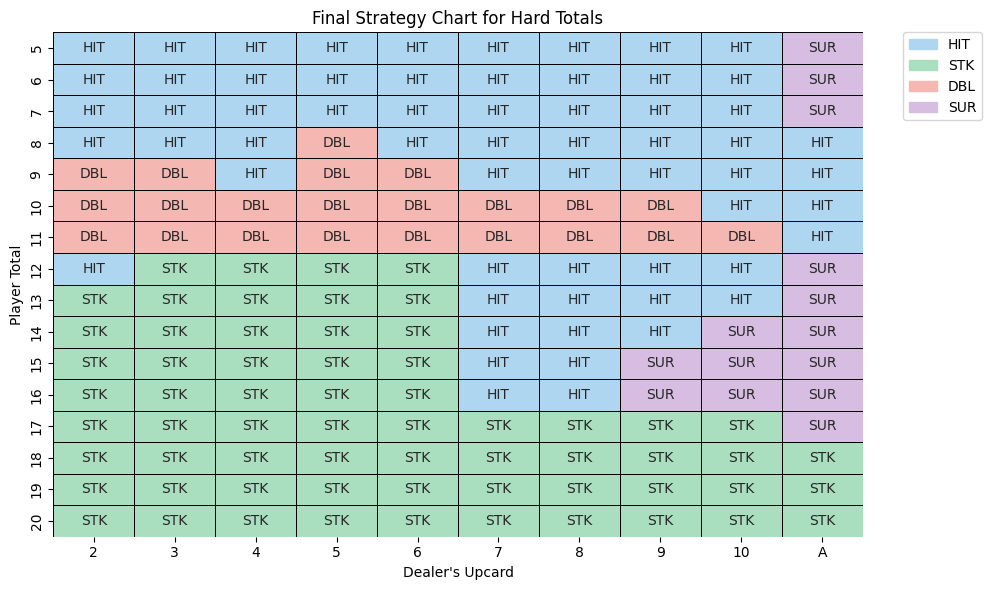

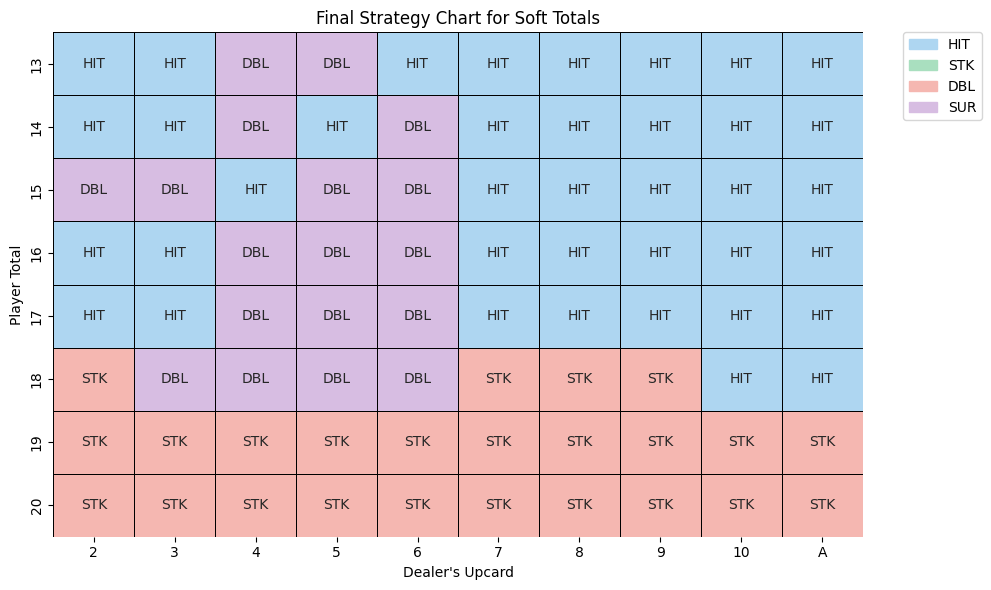

In [8]:
# -------------------------
# 4B. FINAL STRATEGY CHART VISUALISATION
# -------------------------
import seaborn as sns
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap

# We'll use the same mapping of actions to names
actions_map = {0: "HIT", 1: "STK", 2: "DBL", 3: "SUR"}

# For visualization, we first map the action strings to numeric codes.
# We'll assign each action a unique number for color-coding.
action_to_num = {"HIT": 0, "STK": 1, "DBL": 2, "SUR": 3, "-": np.nan}

# Convert the strategy DataFrames (which contain action strings) to numeric DataFrames.
df_hard_num = df_hard.replace(action_to_num)
df_soft_num = df_soft.replace(action_to_num)

# Define a custom colormap with four distinct colors.
# (You can adjust these colors as desired.)
custom_cmap = ListedColormap(["#AED6F1", "#A9DFBF", "#F5B7B1", "#D7BDE2"])

# Create legend handles for the four actions.
legend_handles = [
    mpatches.Patch(color="#AED6F1", label="HIT"),
    mpatches.Patch(color="#A9DFBF", label="STK"),
    mpatches.Patch(color="#F5B7B1", label="DBL"),
    mpatches.Patch(color="#D7BDE2", label="SUR")
]

# -------------------------
# Plot for Hard Totals
# -------------------------
plt.figure(figsize=(10, 6))
ax = sns.heatmap(df_hard_num, 
                 annot=df_hard,       # annotate with the action strings
                 cmap=custom_cmap, 
                 cbar=False, 
                 linewidths=0.5, 
                 linecolor='black', 
                 fmt="")
ax.set_title("Final Strategy Chart for Hard Totals")
ax.set_ylabel("Player Total")
ax.set_xlabel("Dealer's Upcard")
# Add the legend outside the heatmap
plt.legend(handles=legend_handles, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.tight_layout()
plt.show()

# -------------------------
# Plot for Soft Totals
# -------------------------
plt.figure(figsize=(10, 6))
ax2 = sns.heatmap(df_soft_num, 
                  annot=df_soft,       # annotate with the action strings
                  cmap=custom_cmap, 
                  cbar=False, 
                  linewidths=0.5, 
                  linecolor='black', 
                  fmt="")
ax2.set_title("Final Strategy Chart for Soft Totals")
ax2.set_ylabel("Player Total")
ax2.set_xlabel("Dealer's Upcard")
plt.legend(handles=legend_handles, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.tight_layout()
plt.show()